In [1]:
!pip install --quiet git+https://github.com/ain3007-project/project-utils.git

make turn all images into tiff and xml's into tiff and save them into another repo
save thumbnails into a thumbnails repo for visual inspection


In [2]:
raw_repo_id = "ain3007-project/raw-dataset"
FINAL_IMAGE_SIZE = 512
pad_images = True

output_repo_id = f"ain3007-project/dataset-thumbnails-{FINAL_IMAGE_SIZE}"

if pad_images:
    output_repo_id += "-padded"

In [3]:
import huggingface_hub as hfh
import pandas as pd
from project_utils.preprocessing import process
from project_utils.plotting import plot_image_mask_by_path

In [4]:
hfh.login("INSERT TOKEN HERE")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
hfh.utils.disable_progress_bars()

In [6]:
hfh.create_repo(repo_id=output_repo_id, repo_type="dataset",private=True, exist_ok=True)

RepoUrl('https://huggingface.co/datasets/ain3007-project/dataset-thumbnails-512-padded', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ain3007-project/dataset-thumbnails-512-padded')

In [7]:
all_files_raw = list(hfh.list_files_info(repo_id=raw_repo_id, repo_type="dataset"))
all_files_raw[0]

RepoFile(path='.gitattributes', size=33568, blob_id='8960f8cc72aabf94beb88eb49e8ca0a0f242795f', lfs=None, last_commit=None, security=None)

In [8]:
file_names = list(map(lambda x: x.rfilename, all_files_raw))
file_names.remove(".gitattributes")
file_names.remove("Prostate1__he/._00a76bfbec239fd9f465d6581806ff42.tiff")
len(file_names), file_names[0]

(1457, 'Breast1__he/TCGA-A1-A0SM-01Z-00-DX1.svs')

In [9]:
breast1_files = [i.replace(".svs", "") for i in file_names if i.endswith("svs")]
breast1_files = [(i+"*", i+".svs", i+".xml") for i in breast1_files]
len(breast1_files), breast1_files[0]

(40,
 ('Breast1__he/TCGA-A1-A0SM-01Z-00-DX1*',
  'Breast1__he/TCGA-A1-A0SM-01Z-00-DX1.svs',
  'Breast1__he/TCGA-A1-A0SM-01Z-00-DX1.xml'))

In [10]:
breast2_files = [i.replace(".mrxs", "") for i in file_names if i.endswith("mrxs")]
breast2_files = [((i+"/*", i+".*"), i+".mrxs", i+".xml") for i in breast2_files]
len(breast2_files), breast2_files[0]

(40,
 (('Breast2__he/1/*', 'Breast2__he/1.*'),
  'Breast2__he/1.mrxs',
  'Breast2__he/1.xml'))

In [11]:
breast3_files = [i.replace(".ndpi", "") for i in file_names if i.endswith("ndpi")]
breast3_files = [(i+"*", i+".ndpi", i+".xml") for i in breast3_files]
len(breast3_files), breast3_files[0]

(40,
 ('Breast3__ihc/04_HER2*',
  'Breast3__ihc/04_HER2.ndpi',
  'Breast3__ihc/04_HER2.xml'))

In [12]:
lymph1_files = [i.replace(".tif", "") for i in file_names if i.endswith("tif")]
lymph1_files = [(i+"*", i+".tif", i+".xml") for i in lymph1_files]
len(lymph1_files), lymph1_files[0]

(40,
 ('LymphNode1__he/patient_002_node_1*',
  'LymphNode1__he/patient_002_node_1.tif',
  'LymphNode1__he/patient_002_node_1.xml'))

In [13]:
prostate1_files = [i.replace(".tiff", "") for i in file_names if i.endswith("tiff")]
prostate1_files = [(i+"*", i+".tiff", None) for i in prostate1_files]
len(prostate1_files), prostate1_files[0]

(40,
 ('Prostate1__he/0005f7aaab2800f6170c399693a96917*',
  'Prostate1__he/0005f7aaab2800f6170c399693a96917.tiff',
  None))

In [14]:
!mkdir images masks
api = hfh.HfApi()

In [15]:
metadata_df = pd.DataFrame(columns=["image_id", "file_name", "source_dataset", "image-dimension_x", "image-dimension_y", "image-levels", "image-format", "mask_shrink_factor"])
metadata_df

,image_id,file_name,source_dataset,image-dimension_x,image-dimension_y,image-levels,image-format,mask_shrink_factor


In [16]:
image_idx = 0
image_idx, metadata_df = process(
    breast1_files,
    image_idx,
    metadata_df,
    thumbnail_size=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE),
    source_folder_name="Breast1",
    raw_repo_id=raw_repo_id,
    pad_images=pad_images
)
image_idx

finished 0 image of Breast1
finished 1 image of Breast1
finished 2 image of Breast1
finished 3 image of Breast1
finished 4 image of Breast1
finished 5 image of Breast1
finished 6 image of Breast1
finished 7 image of Breast1
finished 8 image of Breast1
finished 9 image of Breast1
finished 10 image of Breast1
finished 11 image of Breast1
finished 12 image of Breast1
finished 13 image of Breast1
finished 14 image of Breast1
finished 15 image of Breast1
finished 16 image of Breast1
finished 17 image of Breast1
finished 18 image of Breast1
finished 19 image of Breast1
finished 20 image of Breast1
finished 21 image of Breast1
finished 22 image of Breast1
finished 23 image of Breast1
finished 24 image of Breast1
finished 25 image of Breast1
finished 26 image of Breast1
finished 27 image of Breast1
finished 28 image of Breast1
finished 29 image of Breast1
finished 30 image of Breast1
finished 31 image of Breast1
finished 32 image of Breast1
finished 33 image of Breast1
finished 34 image of Bre

40

In [17]:
image_idx, metadata_df = process(
    breast2_files,
    image_idx,
    metadata_df,
    thumbnail_size=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE),
    source_folder_name="Breast2",
    raw_repo_id=raw_repo_id,
    pad_images=pad_images
)
image_idx

finished 40 image of Breast2
finished 41 image of Breast2
finished 42 image of Breast2
finished 43 image of Breast2
finished 44 image of Breast2
finished 45 image of Breast2
finished 46 image of Breast2
finished 47 image of Breast2
finished 48 image of Breast2
finished 49 image of Breast2
finished 50 image of Breast2
finished 51 image of Breast2
finished 52 image of Breast2
Annotation label must be either tissue or bg but found: roi
finished 53 image of Breast2
finished 54 image of Breast2
finished 55 image of Breast2
finished 56 image of Breast2
finished 57 image of Breast2
finished 58 image of Breast2
finished 59 image of Breast2
finished 60 image of Breast2
finished 61 image of Breast2
finished 62 image of Breast2
finished 63 image of Breast2
finished 64 image of Breast2
finished 65 image of Breast2
finished 66 image of Breast2
finished 67 image of Breast2
finished 68 image of Breast2
finished 69 image of Breast2
finished 70 image of Breast2
finished 71 image of Breast2
finished 72 

80

In [18]:
image_idx, metadata_df = process(
    breast3_files,
    image_idx,
    metadata_df,
    thumbnail_size=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE),
    source_folder_name="Breast3",
    raw_repo_id=raw_repo_id,
    pad_images=pad_images
)
image_idx

finished 80 image of Breast3
finished 81 image of Breast3
finished 82 image of Breast3
finished 83 image of Breast3
finished 84 image of Breast3
finished 85 image of Breast3
finished 86 image of Breast3
finished 87 image of Breast3
finished 88 image of Breast3
finished 89 image of Breast3
finished 90 image of Breast3
finished 91 image of Breast3
finished 92 image of Breast3
finished 93 image of Breast3
finished 94 image of Breast3
finished 95 image of Breast3
finished 96 image of Breast3
finished 97 image of Breast3
finished 98 image of Breast3
finished 99 image of Breast3
finished 100 image of Breast3
finished 101 image of Breast3
finished 102 image of Breast3
finished 103 image of Breast3
finished 104 image of Breast3
finished 105 image of Breast3
finished 106 image of Breast3
finished 107 image of Breast3
finished 108 image of Breast3
finished 109 image of Breast3
finished 110 image of Breast3
finished 111 image of Breast3
finished 112 image of Breast3
finished 113 image of Breast3


120

In [19]:
image_idx, metadata_df = process(
    lymph1_files,
    image_idx,
    metadata_df,
    thumbnail_size=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE),
    source_folder_name="Lymph1",
    raw_repo_id=raw_repo_id,
    pad_images=pad_images
)
image_idx

Annotation label must be either tissue or bg but found: roi
finished 120 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 121 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 122 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 123 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 124 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 125 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 126 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 127 image of Lymph1
image LymphNode1__he/patient_044_node_0.tif didnt get recognized by OpenSlide. OpenSlideUnsupportedFormatError
Annotation label must be either tissue or bg but found: roi
finished 129 image of Lymph1
Annotation label must be either tissue or bg but found: roi
finished 130 image of Lymph1

hf_folder/datasets--ain3007-project--raw-dataset/snapshots/657934f16e042b975b5aba440fd064fad5cbdfdc/LymphNode1__he/patient_092_node_0.tif: Failed to allocate memory for to read TIFF directory (0 elements of 20 bytes each).
TIFFReadDirectory: Failed to read directory at offset 871004154.


image LymphNode1__he/patient_096_node_0.tif didnt get recognized by OpenSlide. OpenSlideUnsupportedFormatError


hf_folder/datasets--ain3007-project--raw-dataset/snapshots/657934f16e042b975b5aba440fd064fad5cbdfdc/LymphNode1__he/patient_097_node_0.tif: Failed to allocate memory for to read TIFF directory (0 elements of 20 bytes each).
TIFFReadDirectory: Failed to read directory at offset 444340392.


image LymphNode1__he/patient_097_node_0.tif didnt get recognized by OpenSlide. OpenSlideError
image LymphNode1__he/patient_098_node_0.tif didnt get recognized by OpenSlide. OpenSlideUnsupportedFormatError


160

In [20]:
image_idx, metadata_df = process(
    prostate1_files,
    image_idx,
    metadata_df,
    thumbnail_size=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE),
    source_folder_name="Prostate1",
    raw_repo_id=raw_repo_id,
    pad_images=pad_images
)
image_idx

finished 160 image of Prostate1
finished 161 image of Prostate1
finished 162 image of Prostate1
finished 163 image of Prostate1
finished 164 image of Prostate1
image Prostate1__he/003046e27c8ead3e3db155780dc5498e.tiff didnt get recognized by OpenSlide. OpenSlideUnsupportedFormatError
finished 166 image of Prostate1
finished 167 image of Prostate1
finished 168 image of Prostate1
finished 169 image of Prostate1
image Prostate1__he/004391d48d58b18156f811087cd38abf.tiff didnt get recognized by OpenSlide. OpenSlideUnsupportedFormatError
finished 171 image of Prostate1
finished 172 image of Prostate1
finished 173 image of Prostate1
finished 174 image of Prostate1
finished 175 image of Prostate1
finished 176 image of Prostate1
finished 177 image of Prostate1
finished 178 image of Prostate1
finished 179 image of Prostate1
finished 180 image of Prostate1
finished 181 image of Prostate1
finished 182 image of Prostate1
image Prostate1__he/0125392d1963a6b69a37f9e30333d68a.tiff didnt get recognized

200

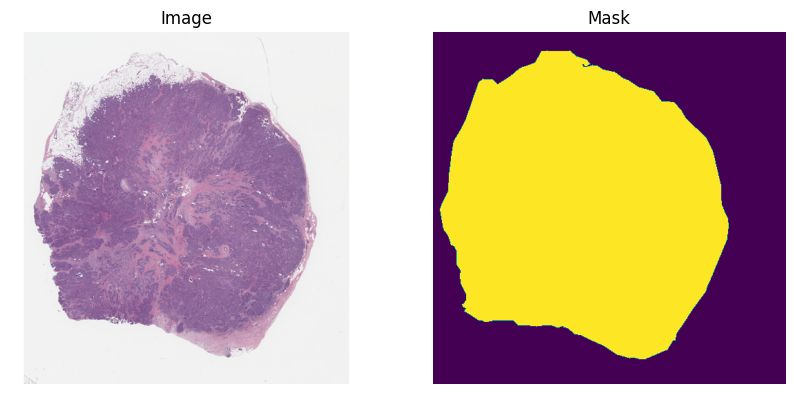

In [21]:
plot_image_mask_by_path("images/2.png", "masks/2.png")


In [22]:
metadata_df.to_csv("metadata.csv", index=False)

In [23]:
api = hfh.HfApi()

# upload zipped folder
!zip -r images.zip images
!zip -r masks.zip masks

api.upload_file(
    path_or_fileobj="images.zip",
    path_in_repo="images.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="masks.zip",
    path_in_repo="masks.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="metadata.csv",
    path_in_repo="metadata.csv",
    repo_id=output_repo_id,
    repo_type="dataset",
)

  adding: images/ (stored 0%)
  adding: images/129.png (deflated 0%)
  adding: images/72.png (deflated 3%)
  adding: images/15.png (deflated 0%)
  adding: images/23.png (deflated 0%)
  adding: images/137.png (deflated 2%)
  adding: images/20.png (deflated 0%)
  adding: images/112.png (deflated 5%)
  adding: images/118.png (deflated 4%)
  adding: images/10.png (deflated 2%)
  adding: images/113.png (deflated 4%)
  adding: images/167.png (deflated 5%)
  adding: images/147.png (deflated 9%)
  adding: images/115.png (deflated 2%)
  adding: images/24.png (deflated 0%)
  adding: images/49.png (deflated 6%)
  adding: images/171.png (deflated 3%)
  adding: images/4.png (deflated 3%)
  adding: images/51.png (deflated 5%)
  adding: images/122.png (deflated 3%)
  adding: images/103.png (deflated 5%)
  adding: images/41.png (deflated 3%)
  adding: images/125.png (deflated 10%)
  adding: images/67.png (deflated 21%)
  adding: images/162.png (deflated 2%)
  adding: images/94.png (deflated 6%)
  addi

'https://huggingface.co/datasets/ain3007-project/dataset-thumbnails-512-padded/blob/main/metadata.csv'